# Double-Bracket Iteration Strategy: Pauli-Z products

In this example, we demonstrate the usage of a DBI strategy, where the diagonal operators for double bracket iterations are variationally chosen from all possible local Pauli-Z operators.

### Initial setup

In [ ]:
!python -m pip install seaborn # plotting library
!python -m pip install hyperopt # required to optimize the DBF step

In [1]:
from copy import copy, deepcopy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from qibo import hamiltonians, set_backend
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketIteration
from qibo.models.dbi.utils import *

Below are some useful functions to visualize the diagonalization process.

In [2]:
def visualize_matrix(matrix, title=""):
    """Visualize absolute values of a matrix in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(title)
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)


def visualize_drift(h0, h):
    """Visualize drift of the evolved hamiltonian w.r.t. h0."""
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(r"Drift: $|\hat{H}_0 - \hat{H}_{1}|$")
    try:
        im = ax.imshow(np.absolute(h0 - h), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute((h0 - h).get()), cmap="inferno")

    fig.colorbar(im, ax=ax)


def plot_histories(loss_histories: list, steps: list, labels: list = None):
    """Plot off-diagonal norm histories over a sequential evolution."""
    plt.figure(figsize=(5, 5 * 6 / 8))
    if len(steps) == 1:
        # fixed_step
        x_axis = [i * steps[0] for i in range(len(loss_histories))]
    else:
        x_axis = [sum(steps[:k]) for k in range(1, len(steps) + 1)]
    plt.plot(x_axis, loss_histories, "-o")

    x_labels_rounded = [round(x, 2) for x in x_axis]
    x_labels_rounded = [0] + x_labels_rounded[0:5] + [max(x_labels_rounded)]
    x_labels_rounded.pop(3)
    plt.xticks(x_labels_rounded)

    y_labels_rounded = [round(y, 1) for y in loss_histories]
    y_labels_rounded = y_labels_rounded[0:5] + [min(y_labels_rounded)]
    plt.yticks(y_labels_rounded)

    if labels is not None:
        labels_copy = copy(labels)
        labels_copy.insert(0, "Initial")
        for i, label in enumerate(labels_copy):
            plt.text(x_axis[i], loss_histories[i], label)

    plt.grid()
    plt.xlabel(r"Flow duration $s$")
    plt.title("Loss function histories")

# Example: TFIM

As an example, we consider the Transverse Field Ising Model (TFIM):
$$ H_{\rm TFIM} = - \sum_{i=1}^{N}\bigl( Z_i Z_{i+1} + h X_i \bigr),$$
which is already implemented in `Qibo`. For this tutorial we set $N=5$ and $h=3$.

In [3]:
# set the qibo backend (we suggest qibojit if N >= 20)
# alternatives: tensorflow (not optimized), numpy (when CPU not supported by jit)
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 5
h = 3

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# initialize class
# Note: use deepcopy to prevent h being edited
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator)
print("Initial off diagonal norm", dbi.off_diagonal_norm)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[Qibo 0.2.4|INFO|2024-01-24 09:40:57]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 37.94733192202055


### Generate local Pauli-Z operators

In [4]:
generate_local_Z = generate_Z_operators(nqubits)
Z_ops = list(generate_local_Z.values())
Z_names = list(generate_local_Z.keys())

[Qibo 0.2.4|WARNING|2024-01-24 09:40:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-24 09:40:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-24 09:40:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-24 09:40:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-24 09:40:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-24 09:40:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-24 09:40:57]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-24 09:40:57]: Calculating the dens

## Iteration from a list of operators
The idea of this strategy is to chose the Z operator that reduces the off-diagonal norm of the hamiltonian most efficiently. Given a list of operators (np.array), the function `select_best_dbr_generator_and_run` searches for the maximum decrease in off-diagonal norm for each operator and runs one double bracket rotation using the optimal operator from the list.

Note that the hyperopt settings can be set as positional arguments.

In [5]:
NSTEPS = 15
max_evals = 100
step_max = 1
Z_optimal = []
# add in initial values for plotting
off_diagonal_norm_history = [dbi.off_diagonal_norm]
steps = [0]
for _ in range(NSTEPS):
    dbi, idx, step, flip_sign = select_best_dbr_generator(dbi, Z_ops, compare_canonical=False, max_evals=max_evals, step_max=step_max)
    off_diagonal_norm_history.append(dbi.off_diagonal_norm)
    steps.append(steps[-1]+step)
    if flip_sign < 0:
        Z_optimal.append('-' + Z_names[idx])
    else:
        Z_optimal.append(Z_names[idx])
    print(f"New optimized step at iteration {_+1}/{NSTEPS}: {step} with operator {Z_optimal[-1]}, loss {dbi.off_diagonal_norm}")

New optimized step at iteration 1/15: 0.5802922474030862 with operator -IIIZZ, loss 33.11643018090643
New optimized step at iteration 2/15: 0.043359192379253356 with operator ZZZZI, loss 26.19914403314804
New optimized step at iteration 3/15: 0.09265860460897991 with operator -ZZIIZ, loss 22.98019174072421
New optimized step at iteration 4/15: 0.03358282350999491 with operator ZZZZI, loss 18.568952671100934
New optimized step at iteration 5/15: 0.04094014393728044 with operator -ZZIIZ, loss 17.26345497290312
New optimized step at iteration 6/15: 0.07482130385576535 with operator -ZIIIZ, loss 15.845257892068565
New optimized step at iteration 7/15: 0.03720439683578085 with operator ZZZZI, loss 14.548267871851474
New optimized step at iteration 8/15: 0.03641216105706838 with operator -ZZIIZ, loss 13.79425955612947
New optimized step at iteration 9/15: 0.0412368890795281 with operator -IIIZZ, loss 13.122192577713562
New optimized step at iteration 10/15: 0.07361535104393056 with operator 

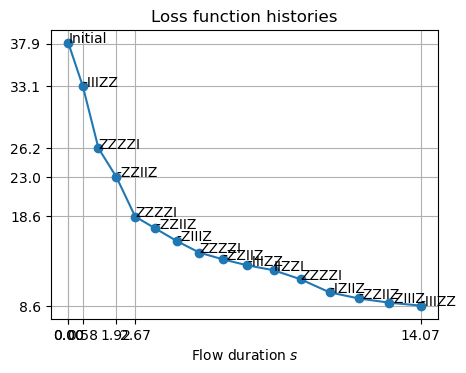

In [6]:
plot_histories(off_diagonal_norm_history, steps, Z_optimal)

It is worth noting that due to the nature of `hyperopt`, the iterations may be unstable and multiple runs may be required for the optimal result (alternatively, we can perform a grid search on the optimal step). Hence, it is sometimes needed to adjust its parameters including the following:

- step_min
- step_max
- max_evals

### Compare with canonical

We compare the effectiveness at diagonalzation between the Pauli-Z operators and the canonical generator:

$$ d = [H,\sigma(H)]$$

In [7]:
# set the qibo backend (we suggest qibojit if N >= 20)
# alternatives: tensorflow (not optimized), numpy (when CPU not supported by jit)
set_backend("qibojit", "numba")


# initialize class|
# Note: use deepcopy to prevent h being edited
dbi_canonical = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.canonical)
print("Initial off diagonal norm", dbi_canonical.off_diagonal_norm)

[Qibo 0.2.4|INFO|2024-01-24 09:43:29]: Using qibojit (numba) backend on /CPU:0


Initial off diagonal norm 37.94733192202055


In [8]:
off_diagonal_norm_history_canonical = [dbi_canonical.off_diagonal_norm]
steps_canonical = [0]
steps_canonical_plot = [0]
for s in range(NSTEPS):
    # same settings as iteration from list
    step = dbi_canonical.hyperopt_step(
        step_min = 1e-5,
        step_max = 1,
        space = hp.uniform,
        optimizer = tpe,
        max_evals = max_evals,
    )
    dbi_canonical(step=step)
    print(f"New optimized step at iteration {s+1}/{NSTEPS}: {step}, loss {dbi_canonical.off_diagonal_norm}")
    off_diagonal_norm_history_canonical.append(dbi_canonical.off_diagonal_norm)
    steps_canonical.append(step)
    steps_canonical_plot.append(steps_canonical_plot[-1]+step)

New optimized step at iteration 1/15: 0.7141252558938868, loss 28.796954985844128
New optimized step at iteration 2/15: 0.013335314667006768, loss 23.150025325565377
New optimized step at iteration 3/15: 0.007151857665536799, loss 21.174565917599644
New optimized step at iteration 4/15: 0.008815389120800888, loss 21.15634538422303
New optimized step at iteration 5/15: 0.005580603223187713, loss 21.152930713031026
New optimized step at iteration 6/15: 0.006206159465007091, loss 21.1528964173955
New optimized step at iteration 7/15: 0.007774031676198437, loss 21.1528939848538
New optimized step at iteration 8/15: 0.010181202791294714, loss 21.15289383684111
New optimized step at iteration 9/15: 0.004841543017323015, loss 21.152893836287003
New optimized step at iteration 10/15: 0.008364467193678036, loss 21.15289383626384
New optimized step at iteration 11/15: 0.006360526619508675, loss 21.152893836260493
New optimized step at iteration 12/15: 0.009108166501832216, loss 21.15289383626047

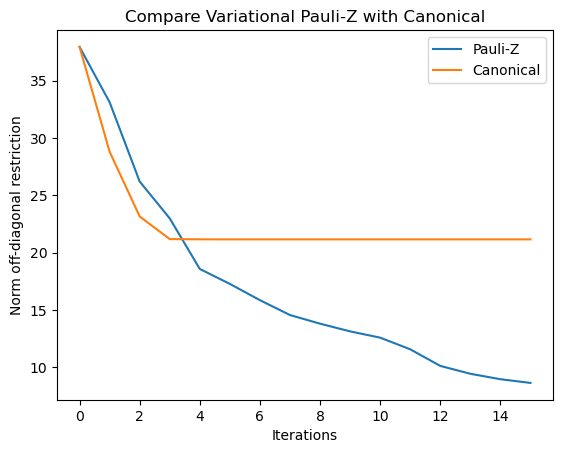

In [9]:
plt.figure()
# plt.plot(steps, off_diagonal_norm_history, label="Pauli-Z")
# plt.plot(steps_canonical, off_diagonal_norm_history_canonical, label="Canonical")
plt.plot(off_diagonal_norm_history, label="Pauli-Z")
plt.plot(off_diagonal_norm_history_canonical, label="Canonical")
plt.xlabel("Iterations")
plt.ylabel("Norm off-diagonal restriction")
plt.title("Compare Variational Pauli-Z with Canonical")
plt.legend()

In [10]:
print(off_diagonal_norm_history)
print(off_diagonal_norm_history_canonical)

[37.94733192202055, 33.11643018090643, 26.19914403314804, 22.98019174072421, 18.568952671100934, 17.26345497290312, 15.845257892068565, 14.548267871851474, 13.79425955612947, 13.122192577713562, 12.573384657978343, 11.558050437409028, 10.107869461324858, 9.421737059033882, 8.946915095665906, 8.623842763568359]
[37.94733192202055, 28.796954985844128, 23.150025325565377, 21.174565917599644, 21.15634538422303, 21.152930713031026, 21.1528964173955, 21.1528939848538, 21.15289383684111, 21.152893836287003, 21.15289383626384, 21.152893836260493, 21.15289383626047, 21.15289383626047, 21.15289383626047, 21.15289383626047]


Here, we make 2 observations:

1. The canonical strategy has a steeper decrease at the beginning than Pauli-Z operators.
2. However, the canonical strategy is also prone to getting stuck at a local minimum and hence resultting in a lesser degree of diagonalization.

Therefore, we explore the possibility of mixing the two strategies by including the canonical generator in the list.

## Mixed strategy: optimal at each step

In [11]:
dbi_mixed = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator)
print("Initial off diagonal norm", dbi_mixed.off_diagonal_norm)

Initial off diagonal norm 37.94733192202055


In [12]:
dbi_eval = deepcopy(dbi_mixed)
dbi_eval.mode = DoubleBracketGeneratorType.canonical
if step is None:
    step = dbi_eval.hyperopt_step(
        step_max=step_max,
        space=hp.uniform,
        optimizer=tpe,
        max_evals=max_evals,
    )
dbi_eval(step=step)
print('canonical norm', dbi_eval.off_diagonal_norm, 'step', step)

canonical norm 37.0169421025245 step 0.0028243313346074067


In [13]:
Z_optimal_mixed = []
# add in initial values for plotting
off_diagonal_norm_history_mixed = [dbi_mixed.off_diagonal_norm]
steps = [0]
for _ in range(NSTEPS):
    dbi_mixed, idx, step, flip_sign = select_best_dbr_generator(dbi_mixed, Z_ops, compare_canonical=True, max_evals=max_evals)
    off_diagonal_norm_history_mixed.append(dbi_mixed.off_diagonal_norm)
    steps.append(steps[-1]+step)
    if idx == len(Z_ops):
        Z_optimal_mixed.append('Canonical')
    elif flip_sign < 0:
        Z_optimal_mixed.append('-' + Z_names[idx])
    else:
        Z_optimal_mixed.append(Z_names[idx])
    print(f"New optimized step at iteration {_+1}/{NSTEPS}: {step} with operator {Z_optimal_mixed[-1]}, loss {dbi_mixed.off_diagonal_norm}")

New optimized step at iteration 1/15: 0.02673042815527681 with operator Canonical, loss 28.931545487398413
New optimized step at iteration 2/15: 0.012489323260897375 with operator Canonical, loss 22.642760635667926
New optimized step at iteration 3/15: 0.08262102611209304 with operator IZIZZ, loss 20.402863400714757
New optimized step at iteration 4/15: 0.005858370590980864 with operator Canonical, loss 17.704347807090855
New optimized step at iteration 5/15: 0.07801470544762314 with operator ZIZIZ, loss 16.35520150538464
New optimized step at iteration 6/15: 0.0024494184523774433 with operator Canonical, loss 15.028787315577059
New optimized step at iteration 7/15: 0.030895838247917303 with operator -ZIIIZ, loss 14.320569882373876


In [ ]:
plt.figure()
# plt.plot(steps, off_diagonal_norm_history, label="Pauli-Z")
# plt.plot(steps_canonical, off_diagonal_norm_history_canonical, label="Canonical")
plt.plot(off_diagonal_norm_history, label="Pauli-Z")
plt.plot(off_diagonal_norm_history_canonical, label="Canonical")
plt.plot(off_diagonal_norm_history_mixed, label="Mixed")
plt.xlabel("Iterations")
plt.ylabel("Norm off-diagonal restriction")
plt.title("Compare Variational Pauli-Z with Canonical")
plt.legend()

After a few tests, we realize that the mixed strategy does not always outperform just using Pauli-Z operators. This could be caused by 2 reasons: 

1. Unstability of hyperopt
2. Tendency of canonical operator to get stuck at a near local minimum

## Mixed strategy: initial canonical

Since the canonical double bracket iteration performs better at the initial steps, we attempt to combine the two strategies: iterate a few steps using the canonical bracket before switching to the variational Z-operators.

In [ ]:
dbi_mixed_can= DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.canonical)
print("Initial off diagonal norm", dbi_mixed_can.off_diagonal_norm)

In [ ]:
# Run the initial iterations using canonical iterations
off_diagonal_norm_history_mixed_can = [dbi_mixed_can.off_diagonal_norm]
steps_mixed_can = [0]
cannonical_NSTEPS = 2
for i in range(cannonical_NSTEPS):
    step = steps_canonical[i+1]
    dbi_mixed_can(step=step)
    off_diagonal_norm_history_mixed_can.append(dbi_mixed_can.off_diagonal_norm)
    steps_mixed_can.append(step)
    
print("After 2 steps, off diagonal norm:", dbi_mixed_can.off_diagonal_norm)
print("By comparison, the Pauli-Z:", off_diagonal_norm_history[2])

In [ ]:
# Continue the remaining steps with Pauli-Z operators
Z_optimal_mixed_can = ["Cannonical" for _ in range(cannonical_NSTEPS)]
remaining_NSTEPS = NSTEPS - cannonical_NSTEPS
dbi_mixed_can.mode = DoubleBracketGeneratorType.single_commutator
for _ in range(remaining_NSTEPS):
    dbi_mixed_can, idx, step, flip_sign = select_best_dbr_generator(dbi_mixed_can, Z_ops, compare_canonical=False)
    off_diagonal_norm_history_mixed_can.append(dbi_mixed_can.off_diagonal_norm)
    steps_mixed_can.append(step)
    if idx == len(Z_ops):
        Z_optimal_mixed.append('Canonical')
    elif flip_sign < 0:
        Z_optimal_mixed.append('-' + Z_names[idx])
    else:
        Z_optimal_mixed.append(Z_names[idx])
    print(f"New optimized step at iteration {_+1}/{remaining_NSTEPS}: {step} with operator {Z_optimal_mixed_can[-1]}")

In [ ]:
plt.figure()
# plt.plot(steps, off_diagonal_norm_history, label="Pauli-Z")
# plt.plot(steps_canonical, off_diagonal_norm_history_canonical, label="Canonical")
plt.plot(off_diagonal_norm_history, label="Pauli-Z")
plt.plot(off_diagonal_norm_history_canonical, label="Canonical")
plt.plot(off_diagonal_norm_history_mixed, label="Mixed: optimal steps")
plt.plot(off_diagonal_norm_history_mixed_can, label="Mixed: initial canonical")
plt.xlabel("Iterations")
plt.ylabel("Norm off-diagonal restriction")
plt.title("Compare Variational Pauli-Z with Canonical")
plt.legend()

This example also shows that the canonical generator is more likely to drive the model into a local minimum than variationally assigned diagonal operator, and that it is hard to get it unstuck even with the Pauli-Z operators.